In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



---

Load Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/cv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cv


In [ ]:
content = '/content/drive/MyDrive/cv/testing/man.jpg'
Style_a = '/content/drive/MyDrive/cv/testing/nicola.jpg' 
Style_b = '/content/drive/MyDrive/cv/testing/sky.jpg'

In [ ]:
def load_image(file_path):
    image = Image.open(file_path).convert('RGB')
    imsize = 512

    transfor_image = transforms.Compose([
        transforms.Resize(imsize),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

    image_tensor = transfor_image(image) 

    
    return image_tensor

In [ ]:
pre_content_img = load_image(content)
pre_Style_a_img = load_image(Style_a)
pre_Style_b_img = load_image(Style_b)

In [ ]:
def im_convert(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

In [ ]:
def show_image(image_tensor, window_name):
    plt.imshow(im_convert(image_tensor))
    plt.title(window_name)
    plt.show()

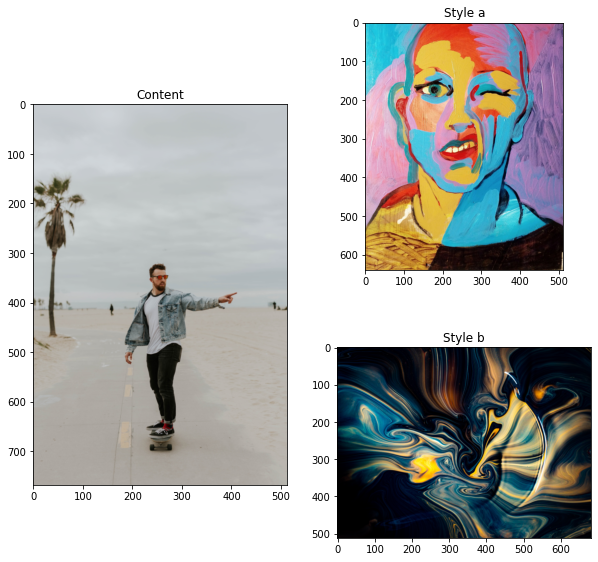

In [ ]:
import matplotlib.gridspec as gridspec
images_n = ["Content","Style a","Style b"]
images_o = [pre_content_img,pre_Style_a_img,pre_Style_b_img]
# Iterate over the subplots and plot each image
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2)
# First axes
ax0 = fig.add_subplot(gs[:, 0])
ax0.set_title(images_n[0])
ax0.imshow(im_convert(images_o[0]))
# Second axes
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title(images_n[1])
ax1.imshow(im_convert(images_o[1]))
# Third axes
ax2 = fig.add_subplot(gs[1,1])
ax2.set_title(images_n[2])
ax2.imshow(im_convert(images_o[2]))
# Show the plot
plt.show()

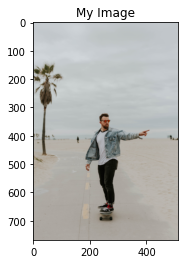

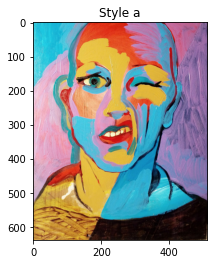

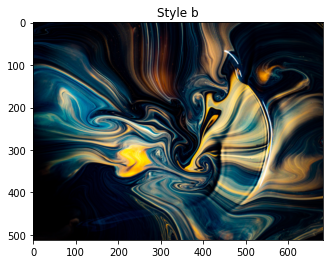

In [ ]:
show_image(pre_content_img,"My Image")
show_image(pre_Style_a_img,"Style a")
show_image(pre_Style_b_img,"Style b")



---

Mixing style

In [ ]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [ ]:
content_img = pre_content_img [:3,:,:].unsqueeze(0)
Style_a_img = pre_Style_a_img [:3,:,:].unsqueeze(0)
Style_b_img = pre_Style_b_img [:3,:,:].unsqueeze(0)

content_img = content_img.to(device)
Style_a_img = Style_a_img.to(device)
Style_b_img = Style_b_img.to(device)

content_features = get_features(content_img, vgg)
style_features_1 = get_features(Style_a_img, vgg)
style_features_2 = get_features(Style_b_img, vgg)

style_grams_1 = {layer: gram_matrix(style_features_1[layer]) for layer in style_features_1}
style_grams_2 = {layer: gram_matrix(style_features_2[layer]) for layer in style_features_2}




In [ ]:
style_weights = {'conv1_1': 1,
                 'conv2_1': 1,
                 'conv3_1': 0.2,
                 'conv4_1': 0.3,
                 'conv5_1': 0.01}



*   Alpha and Beta Experiment(one style)


In [ ]:
def style_transfer(target, content_weight, style_weight):
    show_every = 200

    optimizer = optim.Adam([target], lr=0.003)
    steps = 201 

    for ii in range(1, steps+1):
        target_features = get_features(target, vgg)
        
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        style_loss_1 = 0
        
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape

            style_gram_1 = style_grams_1[layer]
            layer_style_loss_1 = style_weights[layer] * torch.mean((target_gram - style_gram_1)**2)
            style_loss_1 += layer_style_loss_1 / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss_1

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        ratio = content_weight/style_weight 
        
        if  ii % show_every == 0:
            print('Total loss: ', total_loss.item())
            print('Ratio(Alpha/Beta)', ratio)
            plt.imshow(im_convert(target))
            plt.show()
            return target

Total loss:  122.96499633789062
Ratio(Alpha/Beta) 0.1


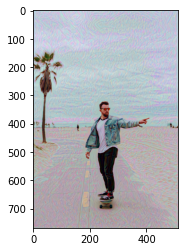

Total loss:  30.5982723236084
Ratio(Alpha/Beta) 0.01


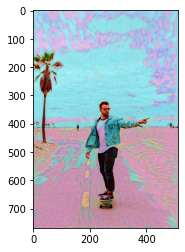

Total loss:  9.84920883178711
Ratio(Alpha/Beta) 0.001


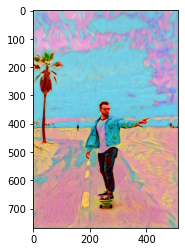

Total loss:  2.285876750946045
Ratio(Alpha/Beta) 0.0001


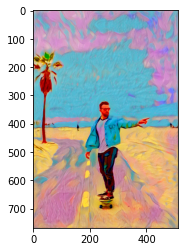

In [ ]:
content_weight = 0.05   # alpha
style_weight = 0.5  # beta
target_one = content_img.clone().requires_grad_(True).to(device)
images = []

for i in range(4):
    
    temp = style_transfer(target_one, content_weight,style_weight).cpu()
    images.append(temp)
    style_weight = style_weight 
    content_weight = content_weight / 10

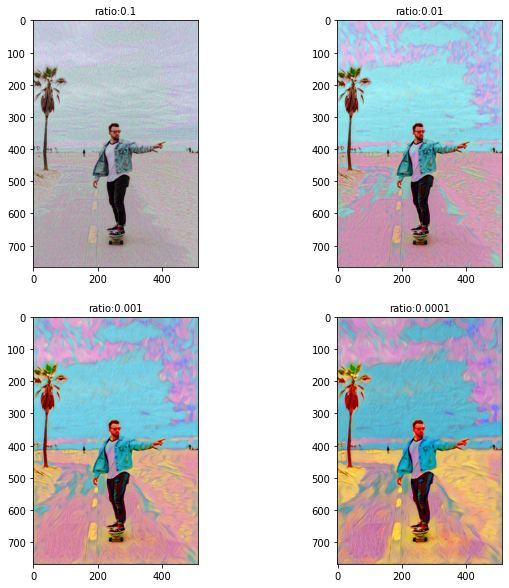

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# Load your images into a list

# Iterate over the subplots and plot each image
for i, axi in enumerate(ax.flat):
    axi.set_title("ratio:"+ str((1)/pow(10,i+1)), fontsize = 10)
    axi.imshow(im_convert(images[i]))

# Show the plot
plt.show()

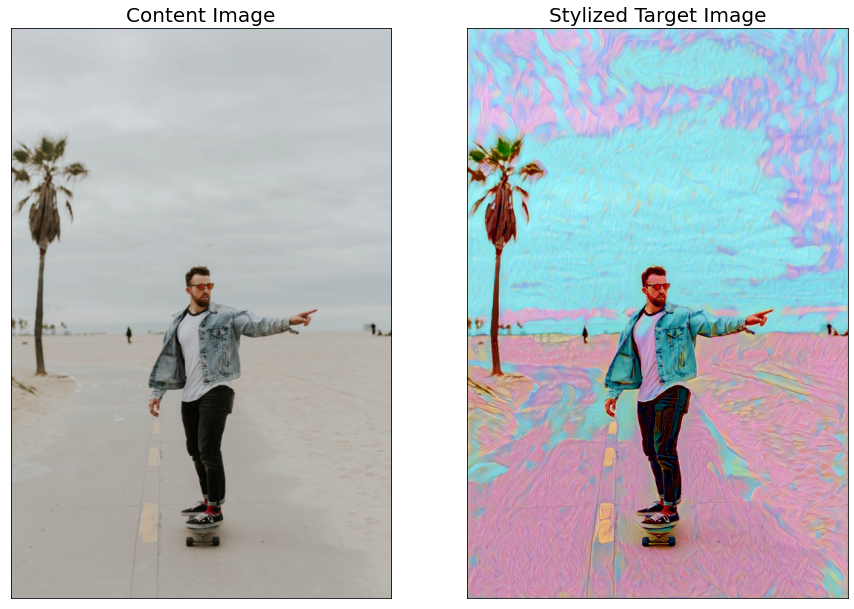

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(im_convert(content_img))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(images[1]))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()



*   Gama(two style)



In [ ]:
gamas = []
for i in range(1,10):
    gamas.append(i/10)
print(gamas)
content_weight = 0.0001   # alpha
style_weight = 0.01  # beta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


Total loss:  1.253497838973999
Gamma:  0.1


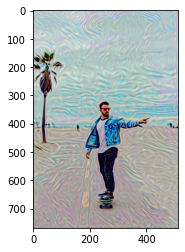

Total loss:  1.541102647781372
Gamma:  0.2


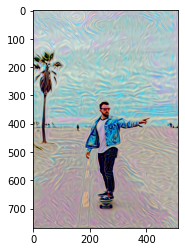

Total loss:  1.7270187139511108
Gamma:  0.3


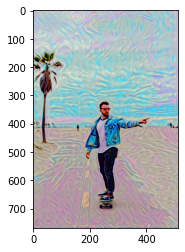

Total loss:  1.8178480863571167
Gamma:  0.4


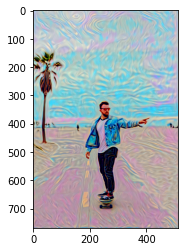

Total loss:  1.8108034133911133
Gamma:  0.5


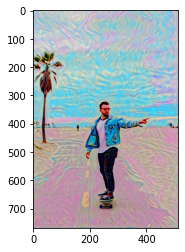

Total loss:  1.702397346496582
Gamma:  0.6


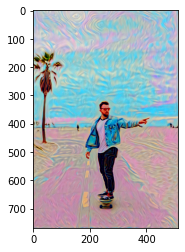

Total loss:  1.4935603141784668
Gamma:  0.7


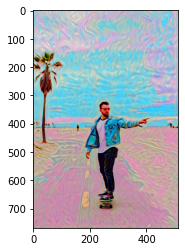

Total loss:  1.1838054656982422
Gamma:  0.8


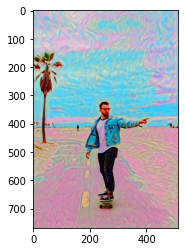

Total loss:  0.7715263366699219
Gamma:  0.9


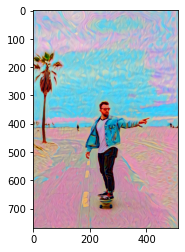

In [ ]:
s1 = []
images_gamas = []
s2 = []
s1_s2 = []
for g in gamas:
    gama = g
    show_every = 200
    target = content_img.clone().requires_grad_(True).to(device)

    optimizer = optim.Adam([target],lr=0.02)
    steps = 200  
    for ii in range(1, steps+1):
        target_features = get_features(target, vgg)
    
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        style_loss_1 = 0
        style_loss_2 = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            
            style_gram_1 = style_grams_1[layer]
            style_gram_2 = style_grams_2[layer]
            layer_style_loss_1 = style_weights[layer] * torch.mean((target_gram - style_gram_1)**2)
            layer_style_loss_2 = style_weights[layer] * torch.mean((target_gram - style_gram_2)**2)

            style_loss_1 += layer_style_loss_1 / (d * h * w)
            style_loss_2 += layer_style_loss_2 / (d * h * w)

        
        if ii == 1:
            L_style_1_content = style_loss_1
            L_style_2_content = style_loss_2
        elif ii == steps:
            L_style_1_generate = style_loss_1
            L_style_2_generate = style_loss_2

        total_loss = content_weight * content_loss + style_weight *gama* style_loss_1+ style_weight*(1-gama)* style_loss_2
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if  ii % show_every == 0:
            
            print('Total loss: ', total_loss.item())
            print('Gamma: ', gama)
            plt.imshow(im_convert(target))
            images_gamas.append(target.cpu())
            plt.show()
            s1_1 = L_style_1_content/L_style_1_generate
            s2_1 =  L_style_2_content/L_style_2_generate
            s1.append(s1_1)
            s2.append(s2_1)
            s1_s2.append(s1_1/s2_1)
            

In [ ]:
s1_list = []
s2_list = []
s1_s2_list = []
for i in range(len(s1)):
    s1_list.append(s1[i].item())
    s2_list.append(s2[i].item())
    s1_s2_list.append(s1_s2[i].item())

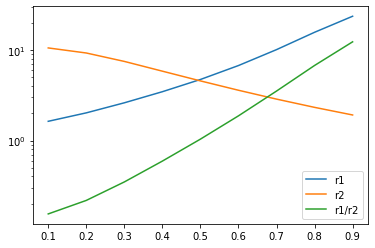

In [ ]:
plt.plot(gamas,s1_list,label='r1')
plt.plot(gamas,s2_list,label='r2')
plt.plot(gamas,s1_s2_list,label='r1/r2')
plt.yscale('log')
plt.legend()

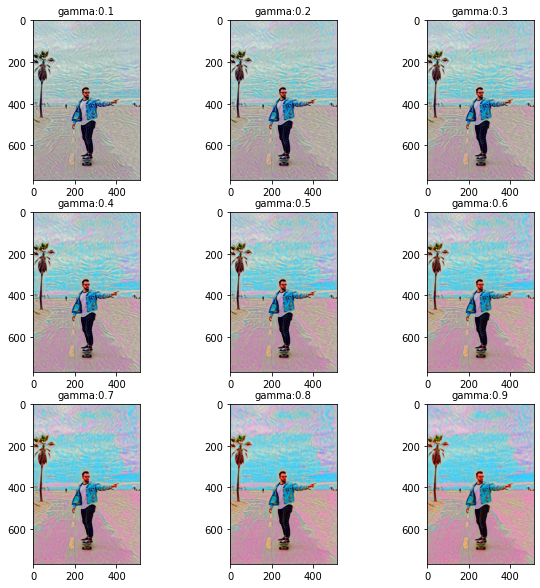

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# Load your images into a list

# Iterate over the subplots and plot each image
for i, axi in enumerate(ax.flat):
    axi.set_title("gamma:"+ str((i+1)/10), fontsize = 10)
    axi.imshow(im_convert(images_gamas[i]))

# Show the plot
plt.show()



---

Background style transfer by detected object

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [ ]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

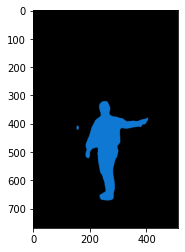

In [ ]:
input_batch = pre_content_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]

content_back = np.transpose(pre_content_img.cpu(), (1, 2, 0)).tolist()
content_people = np.transpose(pre_content_img.cpu(), (1, 2, 0)).tolist()
output_predictions = output.argmax(0)

for i in range(len(output_predictions)):
    for m in range(len(output_predictions[i])):
        if output_predictions[i][m] != 15:
            output_predictions[i][m] = 0
            content_people[i][m] = [255,255,255]
        else:
            content_back[i][m] = [255,255,255]

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")
r = Image.fromarray(output_predictions.byte().cpu().numpy())
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

In [ ]:
content_people = np.transpose(content_people,(2,0,1))
content_people = torch.FloatTensor(content_people).unsqueeze(0)

In [ ]:
content_back = np.transpose(content_back,(2,0,1))
content_back = torch.FloatTensor(content_back).unsqueeze(0)

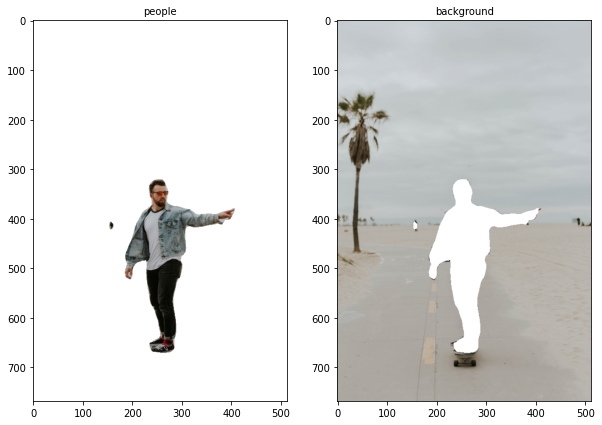

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.set_title('people', fontsize = 10)
ax1.imshow(im_convert(content_people))
ax2.set_title('background', fontsize = 10)
ax2.imshow(im_convert(content_back))



*   backgrounf transfer



In [ ]:
tensor = target.squeeze()
print(tensor.shape)
tensor_list = np.transpose(tensor.cpu().detach().numpy(),(1,2,0)).tolist()

torch.Size([3, 768, 512])


In [ ]:
tensor1 = content_people.squeeze()
print(tensor1.shape)
tensor1 = np.transpose(tensor1.detach().numpy(),(1,2,0)).tolist()

torch.Size([3, 768, 512])


In [ ]:
def im_convert2(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

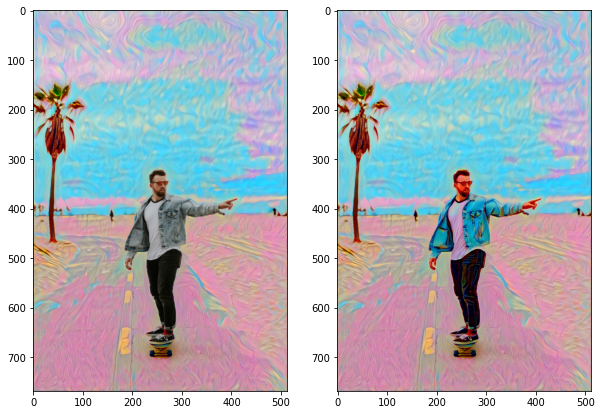

In [ ]:
for n in range(len(tensor1)):
    for m in range(len(tensor1[n])):
        if list(tensor1[n][m]) != [255,255,255]:
            tensor_list[n][m] = tensor1[n][m]

fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(im_convert2(torch.tensor(tensor_list)))

ax[1].imshow(im_convert(target))

plt.show()
